In [1]:
# 02_modeling.ipynb — Block 1
import pandas as pd
import numpy as np

# sklearn basics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, RocCurveDisplay

import matplotlib.pyplot as plt

# load processed features
df = pd.read_csv("../data/processed/features_v1.csv")

print("✅ features loaded:", df.shape)
display(df.head(5))


✅ features loaded: (1800, 20)


,invoice_id,invoice_date,payment_due_date,payment_actual_date,invoice_amount,client_id,client_name,material_name,payment_method,delay_days,delayed_flag,term_days,month,quarter,year,target,client_prev_txn_count,client_prev_total_value,client_prev_delay_rate,client_prev_avg_delay
0,INV00472,2023-01-21,2023-02-20,2023-02-14,216047,C001,ACRON INTERNATIONAL PRIVATE LIMITED,HDPE Pipes,LC,-6,0,30,1,1,2023,0,0,0.0,0.0,0.0
1,INV00193,2023-02-03,2023-03-05,2023-02-27,240835,C001,ACRON INTERNATIONAL PRIVATE LIMITED,TMT Bars,NEFT,-6,0,30,2,1,2023,0,1,216047.0,0.0,0.0
2,INV01088,2023-04-07,2023-05-07,2023-05-04,204797,C001,ACRON INTERNATIONAL PRIVATE LIMITED,HDPE Pipes,NEFT,-3,0,30,4,2,2023,0,2,456882.0,0.0,0.0
3,INV00936,2023-04-14,2023-05-14,2023-05-10,151179,C001,ACRON INTERNATIONAL PRIVATE LIMITED,TMT Bars,NEFT,-4,0,30,4,2,2023,0,3,661679.0,0.0,0.0
4,INV01576,2023-05-17,2023-06-16,2023-06-13,104261,C001,ACRON INTERNATIONAL PRIVATE LIMITED,Binding Wire,Cheque,-3,0,30,5,2,2023,0,4,812858.0,0.0,0.0


In [2]:
# 02_modeling.ipynb — Block 2
# choose features
feature_cols = [
    "invoice_amount","term_days","month","quarter",
    "client_prev_txn_count","client_prev_total_value",
    "client_prev_delay_rate","client_prev_avg_delay"
]

X = df[feature_cols]
y = df["target"]

print("features:", feature_cols)
print("target distribution:", y.value_counts(normalize=True).round(2))


features: ['invoice_amount', 'term_days', 'month', 'quarter', 'client_prev_txn_count', 'client_prev_total_value', 'client_prev_delay_rate', 'client_prev_avg_delay']
target distribution: target
0    0.79
1    0.21
Name: proportion, dtype: float64


In [3]:
# 02_modeling.ipynb — Block 3
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("train:", X_train.shape, "| test:", X_test.shape)


train: (1350, 8) | test: (450, 8)


=== Logistic Regression Report ===
              precision    recall  f1-score   support

           0       0.80      0.55      0.65       354
           1       0.23      0.49      0.31        96

    accuracy                           0.54       450
   macro avg       0.51      0.52      0.48       450
weighted avg       0.68      0.54      0.58       450


Confusion Matrix:
[[195 159]
 [ 49  47]]

ROC-AUC: 0.535


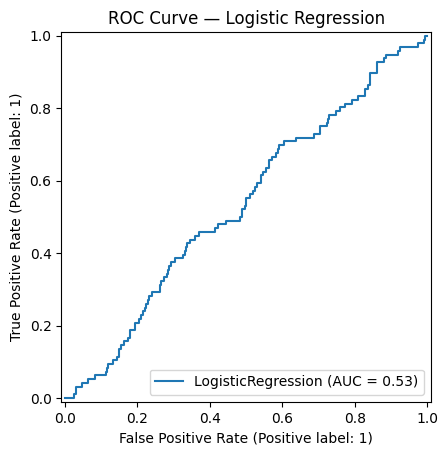

In [4]:
# 02_modeling.ipynb — Block 4
log_reg = LogisticRegression(max_iter=200, class_weight="balanced", random_state=42)
log_reg.fit(X_train_scaled, y_train)

y_pred = log_reg.predict(X_test_scaled)
y_prob = log_reg.predict_proba(X_test_scaled)[:,1]

print("=== Logistic Regression Report ===")
print(classification_report(y_test, y_pred))

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

roc_auc = roc_auc_score(y_test, y_prob)
print("\nROC-AUC:", round(roc_auc,3))

# ROC curve
RocCurveDisplay.from_estimator(log_reg, X_test_scaled, y_test)
plt.title("ROC Curve — Logistic Regression")
plt.show()


=== Random Forest Report ===
              precision    recall  f1-score   support

           0       0.79      0.99      0.88       354
           1       0.50      0.05      0.09        96

    accuracy                           0.79       450
   macro avg       0.65      0.52      0.49       450
weighted avg       0.73      0.79      0.71       450


Confusion Matrix:
[[349   5]
 [ 91   5]]

ROC-AUC: 0.529


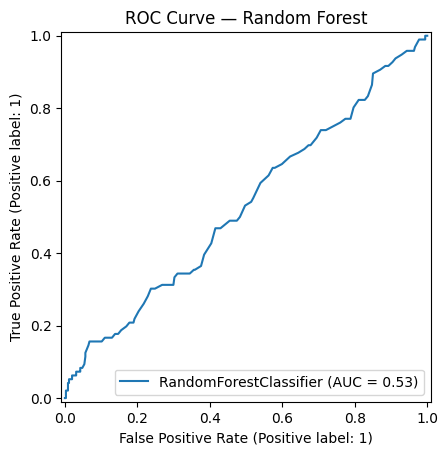

In [5]:
# 02_modeling.ipynb — Block 5
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(
    n_estimators=200,
    max_depth=None,
    class_weight="balanced",
    random_state=42,
    n_jobs=-1
)

rf.fit(X_train, y_train)  # no scaling needed for trees

y_pred_rf = rf.predict(X_test)
y_prob_rf = rf.predict_proba(X_test)[:,1]

print("=== Random Forest Report ===")
print(classification_report(y_test, y_pred_rf))

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred_rf))

roc_auc_rf = roc_auc_score(y_test, y_prob_rf)
print("\nROC-AUC:", round(roc_auc_rf,3))

RocCurveDisplay.from_estimator(rf, X_test, y_test)
plt.title("ROC Curve — Random Forest")
plt.show()


Feature importances:


invoice_amount             0.209
client_prev_total_value    0.195
client_prev_txn_count      0.141
client_prev_delay_rate     0.119
client_prev_avg_delay      0.117
month                      0.098
term_days                  0.084
quarter                    0.037
dtype: float64

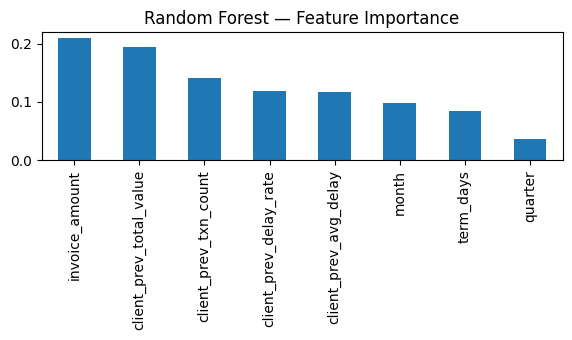

In [6]:
# 02_modeling.ipynb — Block 6
importances = pd.Series(rf.feature_importances_, index=feature_cols).sort_values(ascending=False)

print("Feature importances:")
display(importances.round(3))

plt.figure(figsize=(6,3.5))
importances.plot(kind="bar")
plt.title("Random Forest — Feature Importance")
plt.tight_layout()
plt.show()


In [9]:
# 02_modeling.ipynb — Block 7
# xgboost can be a separate install; handle it gracefully

try:
    from xgboost import XGBClassifier
except ImportError as e:
    print("xgboost not found. run this in a cell:\n!pip install xgboost")
    raise e

xgb = XGBClassifier(
    n_estimators=400,
    learning_rate=0.05,
    max_depth=4,
    subsample=0.9,
    colsample_bytree=0.9,
    reg_lambda=1.0,
    objective="binary:logistic",
    eval_metric="auc",
    random_state=42,
    n_jobs=-1,
    scale_pos_weight=(y_train.value_counts()[0] / y_train.value_counts()[1])  # handle imbalance
)

xgb.fit(X_train, y_train)

y_pred_xgb = xgb.predict(X_test)
y_prob_xgb = xgb.predict_proba(X_test)[:, 1]

from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, RocCurveDisplay

print("=== XGBoost Report ===")
print(classification_report(y_test, y_pred_xgb))

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred_xgb))

roc_auc_xgb = roc_auc_score(y_test, y_prob_xgb)
print("\nROC-AUC:", round(roc_auc_xgb, 3))

RocCurveDisplay.from_estimator(xgb, X_test, y_test)
plt.title("ROC Curve — XGBoost")
plt.show()


=== XGBoost Report ===
              precision    recall  f1-score   support

           0       0.80      0.73      0.76       354
           1       0.24      0.32      0.28        96

    accuracy                           0.64       450
   macro avg       0.52      0.53      0.52       450
weighted avg       0.68      0.64      0.66       450


Confusion Matrix:
[[258  96]
 [ 65  31]]

ROC-AUC: 0.551


AttributeError: 'super' object has no attribute '__sklearn_tags__'

XGBoost feature importance:


client_prev_avg_delay      0.149
client_prev_total_value    0.139
invoice_amount             0.134
client_prev_txn_count      0.130
client_prev_delay_rate     0.127
month                      0.117
term_days                  0.110
quarter                    0.093
dtype: float32

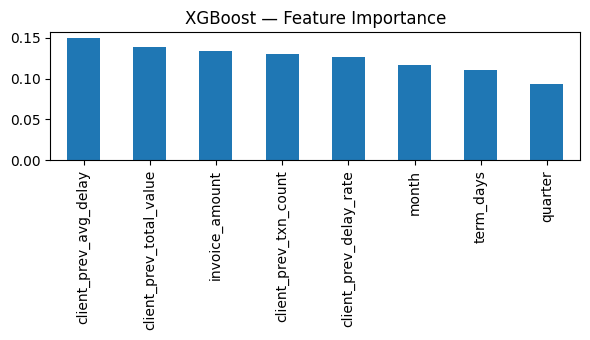

In [10]:
# 02_modeling.ipynb — Block 8
import pandas as pd
import matplotlib.pyplot as plt

xgb_imp = pd.Series(xgb.feature_importances_, index=feature_cols).sort_values(ascending=False)
print("XGBoost feature importance:")
display(xgb_imp.round(3))

plt.figure(figsize=(6,3.5))
xgb_imp.plot(kind="bar")
plt.title("XGBoost — Feature Importance")
plt.tight_layout()
plt.show()


In [13]:
# 02_modeling.ipynb — Block 9
import pandas as pd
from sklearn.model_selection import train_test_split

df = pd.read_csv("../data/processed/features_v2.csv", parse_dates=["invoice_date","payment_due_date","payment_actual_date"])

# pick features (include our new ones + the historicals)
base_cols = [
    "invoice_amount","log_amount","term_days","month","quarter","year",
    "is_month_end","is_quarter_end","days_to_month_end","due_dow","inv_dow",
    "client_prev_txn_count","client_prev_total_value","client_prev_delay_rate","client_prev_avg_delay",
    "client_amount_z","client_rolling_90_value"
]
# add one-hot columns (material & payment_method)
onehots = [c for c in df.columns if c.startswith("payment_method_") or c.startswith("material_name_")]

feature_cols = base_cols + onehots
target_col = "target"

df = df.sort_values("invoice_date")

# simple time split: train up to 2025-03-31, test from 2025-04-01 onwards
split_date = pd.Timestamp("2025-04-01")
train = df[df["invoice_date"] < split_date].copy()
test  = df[df["invoice_date"] >= split_date].copy()

X_train, y_train = train[feature_cols], train[target_col]
X_test, y_test   = test[feature_cols],  test[target_col]

print("train:", X_train.shape, "| test:", X_test.shape, "| cutoff:", split_date.date())



train: (1510, 35) | test: (290, 35) | cutoff: 2025-04-01


=== Random Forest (rich features) ===
              precision    recall  f1-score   support

           0       0.76      0.98      0.86       221
           1       0.00      0.00      0.00        69

    accuracy                           0.75       290
   macro avg       0.38      0.49      0.43       290
weighted avg       0.58      0.75      0.65       290


Confusion Matrix:
 [[217   4]
 [ 69   0]]

ROC-AUC: 0.516


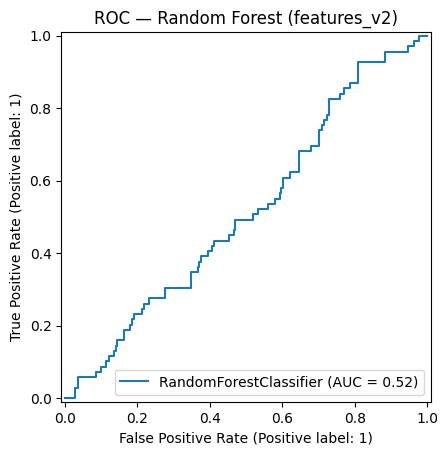


Top feature drivers:


client_amount_z            0.091
client_rolling_90_value    0.086
log_amount                 0.081
invoice_amount             0.079
client_prev_total_value    0.078
days_to_month_end          0.072
client_prev_avg_delay      0.065
client_prev_delay_rate     0.064
client_prev_txn_count      0.062
month                      0.049
inv_dow                    0.044
due_dow                    0.041
term_days                  0.036
quarter                    0.022
year                       0.014
dtype: float64

=== Random Forest (rich features) ===
              precision    recall  f1-score   support

           0       0.76      0.98      0.86       221
           1       0.00      0.00      0.00        69

    accuracy                           0.75       290
   macro avg       0.38      0.49      0.43       290
weighted avg       0.58      0.75      0.65       290


Confusion Matrix:
 [[217   4]
 [ 69   0]]

ROC-AUC: 0.516


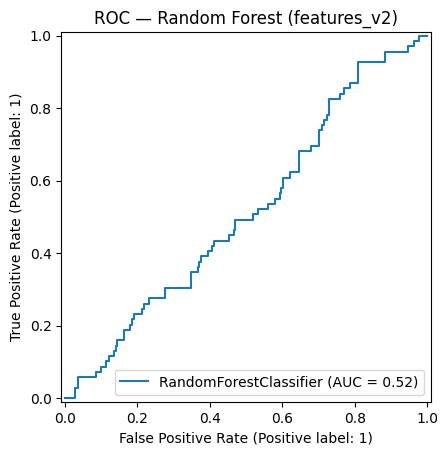


Top feature drivers:


client_amount_z            0.091
client_rolling_90_value    0.086
log_amount                 0.081
invoice_amount             0.079
client_prev_total_value    0.078
days_to_month_end          0.072
client_prev_avg_delay      0.065
client_prev_delay_rate     0.064
client_prev_txn_count      0.062
month                      0.049
inv_dow                    0.044
due_dow                    0.041
term_days                  0.036
quarter                    0.022
year                       0.014
dtype: float64

In [14]:
# 02_modeling.ipynb — Block 10
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, RocCurveDisplay
import matplotlib.pyplot as plt
import pandas as pd

rf = RandomForestClassifier(
    n_estimators=400,
    max_depth=None,
    min_samples_leaf=2,
    class_weight="balanced",
    random_state=42,
    n_jobs=-1
)
rf.fit(X_train, y_train)
y_pred_rf  = rf.predict(X_test)
y_prob_rf  = rf.predict_proba(X_test)[:,1]

print("=== Random Forest (rich features) ===")
print(classification_report(y_test, y_pred_rf))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred_rf))
print("\nROC-AUC:", round(roc_auc_score(y_test, y_prob_rf), 3))

RocCurveDisplay.from_estimator(rf, X_test, y_test)
plt.title("ROC — Random Forest (features_v2)")
plt.show()

# importance
imp = pd.Series(rf.feature_importances_, index=feature_cols).sort_values(ascending=False)
print("\nTop feature drivers:")
display(imp.head(15).round(3))


=== XGBoost (features_v2) ===
              precision    recall  f1-score   support

           0       0.75      0.87      0.81       221
           1       0.15      0.07      0.10        69

    accuracy                           0.68       290
   macro avg       0.45      0.47      0.45       290
weighted avg       0.61      0.68      0.64       290


Confusion Matrix:
 [[193  28]
 [ 64   5]]

ROC-AUC: 0.494


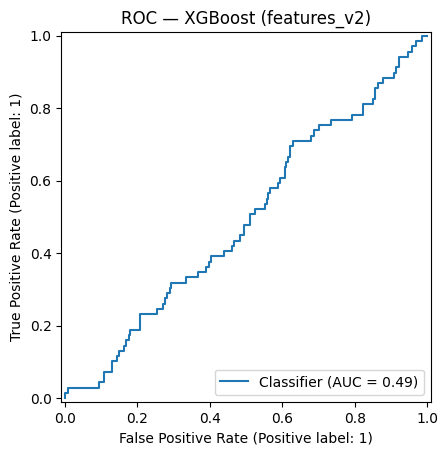


Top XGB drivers (gain):


material_name_Fly Ash             4.792487
material_name_TMT Bars            4.421540
material_name_Stainless Steel     4.237760
material_name_HR Coils            3.868980
payment_method_LC                 3.658360
quarter                           3.495312
year                              3.489557
material_name_Binding Wire        3.340329
material_name_Structural Steel    3.284509
material_name_MS Coils            3.060061
material_name_CR Coils            3.025075
client_prev_delay_rate            3.009926
client_prev_avg_delay             3.006340
material_name_Rebars              2.828915
material_name_Cement              2.800344
dtype: float64

In [15]:
# 02_modeling.ipynb — Block 11
import xgboost as xgb
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix, RocCurveDisplay
import numpy as np
import matplotlib.pyplot as plt

dtrain = xgb.DMatrix(X_train, label=y_train)
dtest  = xgb.DMatrix(X_test,  label=y_test)

params = {
    "objective": "binary:logistic",
    "eval_metric": "auc",
    "eta": 0.05,
    "max_depth": 5,
    "subsample": 0.9,
    "colsample_bytree": 0.9,
    "lambda": 1.0,
    "seed": 42,
    "scale_pos_weight": (y_train.value_counts()[0] / y_train.value_counts()[1])
}
bst = xgb.train(params, dtrain, num_boost_round=600)

y_prob_xgb = bst.predict(dtest)
y_pred_xgb = (y_prob_xgb >= 0.5).astype(int)

print("=== XGBoost (features_v2) ===")
print(classification_report(y_test, y_pred_xgb))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred_xgb))
print("\nROC-AUC:", round(roc_auc_score(y_test, y_prob_xgb),3))

RocCurveDisplay.from_predictions(y_test, y_prob_xgb)
plt.title("ROC — XGBoost (features_v2)")
plt.show()

# importance (gain)
imp_xgb = bst.get_score(importance_type="gain")
imp_xgb = pd.Series(imp_xgb).sort_values(ascending=False)
print("\nTop XGB drivers (gain):")
display(imp_xgb.head(15))


In [16]:
# 02_modeling.ipynb — Block 12
import numpy as np
from sklearn.metrics import precision_recall_curve, average_precision_score

# choose model probs to tune on (rf or xgb); here: xgb
probs = y_prob_xgb

prec, rec, thr = precision_recall_curve(y_test, probs)
ap = average_precision_score(y_test, probs)
print("Average Precision (PR-AUC):", round(ap,3))

# pick threshold for desired recall (e.g., 0.60 to catch 60% of delayed invoices)
target_recall = 0.60
idx = (np.abs(rec - target_recall)).argmin()
chosen_thr = thr[max(idx-1, 0)]
print(f"Chosen threshold at ~{target_recall*100:.0f}% recall:", round(chosen_thr,3))

y_pred_thr = (probs >= chosen_thr).astype(int)
from sklearn.metrics import classification_report, confusion_matrix
print("\n=== Report @ tuned threshold ===")
print(classification_report(y_test, y_pred_thr))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred_thr))


Average Precision (PR-AUC): 0.247
Chosen threshold at ~60% recall: 0.072

=== Report @ tuned threshold ===
              precision    recall  f1-score   support

           0       0.77      0.41      0.53       221
           1       0.24      0.61      0.35        69

    accuracy                           0.46       290
   macro avg       0.51      0.51      0.44       290
weighted avg       0.64      0.46      0.49       290


Confusion Matrix:
 [[ 90 131]
 [ 27  42]]


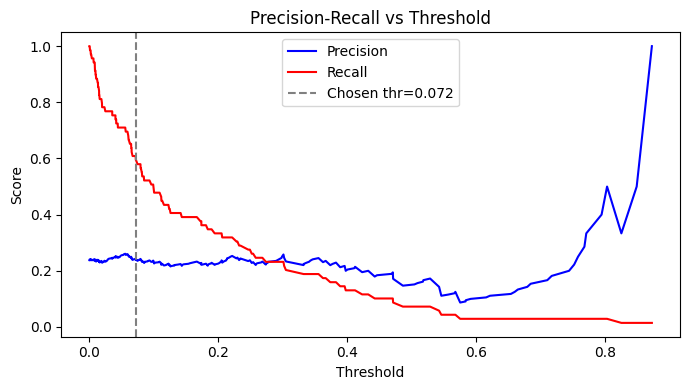

In [17]:
# 02_modeling.ipynb — Block 13
import matplotlib.pyplot as plt

plt.figure(figsize=(7,4))
plt.plot(thr, prec[:-1], label="Precision", color="blue")
plt.plot(thr, rec[:-1], label="Recall", color="red")
plt.axvline(chosen_thr, color="gray", linestyle="--", label=f"Chosen thr={chosen_thr:.3f}")

plt.title("Precision-Recall vs Threshold")
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.legend()
plt.tight_layout()
plt.show()


Permutation Importance (RF):


month                              0.0017
quarter                            0.0017
material_name_HDPE Pipes           0.0003
material_name_MS Coils             0.0000
material_name_PVC Pipes            0.0000
material_name_Plates               0.0000
year                               0.0000
is_quarter_end                     0.0000
payment_method_LC                  0.0000
material_name_Cement               0.0000
is_month_end                       0.0000
material_name_CR Coils             0.0000
material_name_Galvanized Sheets    0.0000
material_name_Structural Steel     0.0000
material_name_Rebars               0.0000
dtype: float64

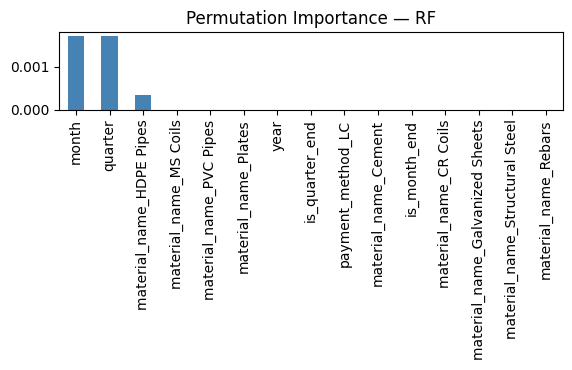

In [21]:
from sklearn.inspection import permutation_importance
import pandas as pd
import matplotlib.pyplot as plt

perm = permutation_importance(rf, X_test, y_test, n_repeats=10, random_state=42, n_jobs=-1)

imp_perm = pd.Series(perm.importances_mean, index=X_test.columns).sort_values(ascending=False)
print("Permutation Importance (RF):")
display(imp_perm.head(15).round(4))

# simple bar chart without sklearn internals
plt.figure(figsize=(6,3.8))
imp_perm.head(15).plot(kind="bar", color="steelblue")
plt.title("Permutation Importance — RF")
plt.tight_layout()
plt.show()


In [22]:
# 02_modeling.ipynb — Block 15
# pick a risky invoice (model thinks high prob)
test_copy = X_test.copy()
test_copy["true"] = y_test
test_copy["prob_rf"] = y_prob_rf
test_copy_sorted = test_copy.sort_values("prob_rf", ascending=False)

sample = test_copy_sorted.head(1)  # top risky invoice
print("Sample risky invoice:\n")
display(sample)

# reason codes via feature contributions (approx: difference if permuted)
row = sample[feature_cols].iloc[0].values.reshape(1,-1)

# crude approximation: feature impact = score drop if permuted
reason_imp = {}
for i, col in enumerate(feature_cols):
    X_tmp = X_test.copy()
    X_tmp[col] = np.random.permutation(X_tmp[col])  # permute only this col
    prob_tmp = rf.predict_proba(X_tmp)[:,1]
    reason_imp[col] = np.mean(y_prob_rf - prob_tmp)

reason_sorted = pd.Series(reason_imp).sort_values(ascending=False)
print("\nTop drivers for this invoice:\n")
display(reason_sorted.head(5).round(4))


Sample risky invoice:



,invoice_amount,log_amount,term_days,month,quarter,year,is_month_end,is_quarter_end,days_to_month_end,due_dow,...,material_name_HR Coils,material_name_MS Coils,material_name_PVC Pipes,material_name_Plates,material_name_Rebars,material_name_Stainless Steel,material_name_Structural Steel,material_name_TMT Bars,true,prob_rf
1494,107596,11.586148,15,5,2,2025,0,0,21,6,...,False,False,False,False,False,True,False,False,0,0.609045



Top drivers for this invoice:



material_name_Stainless Steel    0.0037
client_rolling_90_value          0.0016
client_prev_txn_count            0.0014
inv_dow                          0.0010
term_days                        0.0007
dtype: float64